In [1]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pickle

df1 = pd.read_csv(".\\csvs\\2018trans.csv")
df2 = pd.read_csv(".\\csvs\\2019trans.csv")
df3 = pd.read_csv(".\\csvs\\2020trans.csv")
df4 = pd.read_csv(".\\csvs\\extraData.csv")

df = pd.concat([df1,df2,df3,df4])
df.name = df.name.replace(to_replace ='#\w*\d+', value = '', regex = True)
df.drop_duplicates()

df.head()


,name,category
0,MCDONALD'S,Restaurants
1,CORNER KITCHEN,Restaurants
2,JOHN JUAN BURGER & BURRIT,Restaurants
3,HEART & CROWN BYWARD M,Restaurants
4,UBER TRIP COTAA HELP.UB,Transportation


In [2]:
# encodings categories
filename = r'.\saved\categoryEncoder.sav'
en = pickle.load(open(filename, 'rb'))

filename = r'.\saved\countVectorizer.sav'
count_vect = pickle.load(open(filename, 'rb'))

filename = r'.\saved\tfidfTransformer.sav'
tfidf_transformer = pickle.load(open(filename, 'rb'))

filename = r'.\saved\RFclassifier.sav'
rfClf = pickle.load(open(filename, 'rb'))

filename = r'.\saved\rfPipeLine.sav'
rfPipe = pickle.load(open(filename, 'rb'))

#load data
banking_df = pd.read_csv(".\\csvs\\cibcMar_Apr21.csv",names = ["date","name","credit","debt","account"])
banking_df = banking_df.fillna(0)
banking_df

,date,name,credit,debt,account
0,2021-04-28,"THE ATHLETIC PERFORMANCE 9058571131, ON",711.90,0.0,4502********1761
1,2021-04-28,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,800.0,4502********1761
2,2021-04-27,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,335.0,4502********1761
3,2021-04-26,"SKIPTHEDISHES WINNIPEG, MB",53.17,0.0,4502********1761
4,2021-04-26,"JOLLIBEE- MISSISSAUGA MISSISSAUGA, ON",15.56,0.0,4502********1761
...,...,...,...,...,...
132,2020-11-13,"MCDONALD'S #23027 MYMCDS BOLTON, ON",9.04,0.0,4502********1761
133,2020-11-10,"LA SHAWARMA BOLTON, ON",31.62,0.0,4502********1761
134,2020-11-09,"THE ATHLETIC PERFORMANCE 9058571131, ON",72.82,0.0,4502********1761
135,2020-11-09,"CHICK-FIL-A YORKDALE MAL NORTH YORK, ON",28.92,0.0,4502********1761


In [3]:
credit_df = banking_df[banking_df["credit"] == 0]
credit_df

,date,name,credit,debt,account
1,2021-04-28,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,800.00,4502********1761
2,2021-04-27,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,335.00,4502********1761
6,2021-04-26,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,522.00,4502********1761
26,2021-03-30,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,500.00,4502********1761
48,2021-03-03,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,850.00,4502********1761
50,2021-03-02,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,120.00,4502********1761
51,2021-03-02,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,850.00,4502********1761
61,2021-02-17,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,650.00,4502********1761
74,2021-01-28,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,800.00,4502********1761
93,2020-12-31,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,700.00,4502********1761


In [4]:
debt_df = banking_df[banking_df["debt"] == 0]
df.category = df.category.replace(to_replace ='#\w*\d+', value = '', regex = True)
debt_df['name'] = debt_df['name'].replace(to_replace =',\s*[A-Z][A-Z]', value = '', regex = True)
debt_df.name = debt_df.name.replace(to_replace ='#\w*\d+', value = '', regex = True)

debt_df

<ipython-input-4-b06811bd3eef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debt_df['name'] = debt_df['name'].replace(to_replace =',\s*[A-Z][A-Z]', value = '', regex = True)
c:\users\jasman singh sahi\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,date,name,credit,debt,account
0,2021-04-28,THE ATHLETIC PERFORMANCE 9058571131,711.90,0.0,4502********1761
3,2021-04-26,SKIPTHEDISHES WINNIPEG,53.17,0.0,4502********1761
4,2021-04-26,JOLLIBEE- MISSISSAUGA MISSISSAUGA,15.56,0.0,4502********1761
5,2021-04-26,SKIPTHEDISHES WINNIPEG,49.36,0.0,4502********1761
7,2021-04-21,BK BRAMPTON,28.76,0.0,4502********1761
...,...,...,...,...,...
132,2020-11-13,MCDONALD'S MYMCDS BOLTON,9.04,0.0,4502********1761
133,2020-11-10,LA SHAWARMA BOLTON,31.62,0.0,4502********1761
134,2020-11-09,THE ATHLETIC PERFORMANCE 9058571131,72.82,0.0,4502********1761
135,2020-11-09,CHICK-FIL-A YORKDALE MAL NORTH YORK,28.92,0.0,4502********1761


In [5]:
# get x
X_counts = count_vect.fit_transform(debt_df['name'])#(debt_df['name'])
X_tfidf = tfidf_transformer.fit_transform(X_counts)
debt_df['name']

0      THE ATHLETIC PERFORMANCE 9058571131
3                   SKIPTHEDISHES WINNIPEG
4        JOLLIBEE- MISSISSAUGA MISSISSAUGA
5                   SKIPTHEDISHES WINNIPEG
7                             BK  BRAMPTON
                      ...                 
132              MCDONALD'S  MYMCDS BOLTON
133                     LA SHAWARMA BOLTON
134    THE ATHLETIC PERFORMANCE 9058571131
135    CHICK-FIL-A YORKDALE MAL NORTH YORK
136                CITY SOUTH PIZZA BOLTON
Name: name, Length: 122, dtype: object

Xold_counts = count_vect.fit_transform(df4['name'])#(debt_df['name'])
Xold_tfidf = tfidf_transformer.fit_transform(Xold_counts)
df1['name']

# predict
results = rfClf.predict(Xold_tfidf)
results

# transform x

filename = r'.\saved\LinSVCclassifier.sav'
LinSVC = pickle.load(open(filename, 'rb')) 

# predict
results = LinSVC.predict(Xold_tfidf)
results

resultsCategories = en.inverse_transform(result)
print(resultsCategories)

debt_df['cat_id'] = results
debt_df['cat'] = resultsCategories

In [10]:
credit_df['cat'] = "payment"
credit_df['cat_id'] = 100 # add to encoding later 

#rfPipe -> debt_df
res = rfPipe.predict(debt_df['name'])
res

<ipython-input-10-7d88f4178886>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_df['cat'] = "payment"
<ipython-input-10-7d88f4178886>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_df['cat_id'] = 100 # add to encoding later


array([1, 5, 3, 5, 3, 3, 3, 3, 3, 1, 6, 5, 3, 3, 3, 4, 3, 6, 3, 3, 3, 1,
       5, 3, 3, 1, 3, 3, 6, 3, 3, 6, 3, 3, 3, 6, 3, 3, 4, 5, 6, 3, 6, 3,
       1, 3, 1, 6, 6, 5, 6, 3, 3, 4, 0, 3, 5, 5, 3, 3, 5, 3, 4, 1, 5, 5,
       1, 3, 0, 3, 4, 3, 5, 4, 5, 4, 3, 3, 4, 6, 3, 3, 3, 4, 1, 3, 4, 5,
       3, 3, 3, 4, 5, 3, 1, 1, 4, 5, 1, 3, 3, 5, 3, 2, 5, 5, 1, 3, 3, 1,
       3, 0, 3, 5, 1, 3, 3, 3, 3, 1, 3, 3])

In [11]:
resultsCategories = en.inverse_transform(res)
resultsCategories

array(['Entertainment', 'SkipTheDishes', 'Restaurants', 'SkipTheDishes',
       'Restaurants', 'Restaurants', 'Restaurants', 'Restaurants',
       'Restaurants', 'Entertainment', 'Transportation', 'SkipTheDishes',
       'Restaurants', 'Restaurants', 'Restaurants', 'Retail and Grocery',
       'Restaurants', 'Transportation', 'Restaurants', 'Restaurants',
       'Restaurants', 'Entertainment', 'SkipTheDishes', 'Restaurants',
       'Restaurants', 'Entertainment', 'Restaurants', 'Restaurants',
       'Transportation', 'Restaurants', 'Restaurants', 'Transportation',
       'Restaurants', 'Restaurants', 'Restaurants', 'Transportation',
       'Restaurants', 'Restaurants', 'Retail and Grocery',
       'SkipTheDishes', 'Transportation', 'Restaurants', 'Transportation',
       'Restaurants', 'Entertainment', 'Restaurants', 'Entertainment',
       'Transportation', 'Transportation', 'SkipTheDishes',
       'Transportation', 'Restaurants', 'Restaurants',
       'Retail and Grocery', 'Amazon', 

In [12]:
debt_df['cat_id'] = res
debt_df['cat'] = resultsCategories

<ipython-input-12-f819020f9dbd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debt_df['cat_id'] = res
<ipython-input-12-f819020f9dbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debt_df['cat'] = resultsCategories


In [14]:
banking_df.drop(['account'], axis=1)

,date,name,credit,debt
0,2021-04-28,"THE ATHLETIC PERFORMANCE 9058571131, ON",711.90,0.0
1,2021-04-28,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,800.0
2,2021-04-27,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,335.0
3,2021-04-26,"SKIPTHEDISHES WINNIPEG, MB",53.17,0.0
4,2021-04-26,"JOLLIBEE- MISSISSAUGA MISSISSAUGA, ON",15.56,0.0
...,...,...,...,...
132,2020-11-13,"MCDONALD'S #23027 MYMCDS BOLTON, ON",9.04,0.0
133,2020-11-10,"LA SHAWARMA BOLTON, ON",31.62,0.0
134,2020-11-09,"THE ATHLETIC PERFORMANCE 9058571131, ON",72.82,0.0
135,2020-11-09,"CHICK-FIL-A YORKDALE MAL NORTH YORK, ON",28.92,0.0


In [15]:
banking_df

,date,name,credit,debt,account
0,2021-04-28,"THE ATHLETIC PERFORMANCE 9058571131, ON",711.90,0.0,4502********1761
1,2021-04-28,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,800.0,4502********1761
2,2021-04-27,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,335.0,4502********1761
3,2021-04-26,"SKIPTHEDISHES WINNIPEG, MB",53.17,0.0,4502********1761
4,2021-04-26,"JOLLIBEE- MISSISSAUGA MISSISSAUGA, ON",15.56,0.0,4502********1761
...,...,...,...,...,...
132,2020-11-13,"MCDONALD'S #23027 MYMCDS BOLTON, ON",9.04,0.0,4502********1761
133,2020-11-10,"LA SHAWARMA BOLTON, ON",31.62,0.0,4502********1761
134,2020-11-09,"THE ATHLETIC PERFORMANCE 9058571131, ON",72.82,0.0,4502********1761
135,2020-11-09,"CHICK-FIL-A YORKDALE MAL NORTH YORK, ON",28.92,0.0,4502********1761


In [16]:
credit_df # overwrite banking

,date,name,credit,debt,account,cat,cat_id
1,2021-04-28,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,800.00,4502********1761,payment,100
2,2021-04-27,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,335.00,4502********1761,payment,100
6,2021-04-26,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,522.00,4502********1761,payment,100
26,2021-03-30,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,500.00,4502********1761,payment,100
48,2021-03-03,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,850.00,4502********1761,payment,100
50,2021-03-02,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,120.00,4502********1761,payment,100
51,2021-03-02,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,850.00,4502********1761,payment,100
61,2021-02-17,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,650.00,4502********1761,payment,100
74,2021-01-28,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,800.00,4502********1761,payment,100
93,2020-12-31,PAYMENT THANK YOU/PAIEMEN T MERCI,0.0,700.00,4502********1761,payment,100


In [17]:
debt_df

,date,name,credit,debt,account,cat_id,cat
0,2021-04-28,THE ATHLETIC PERFORMANCE 9058571131,711.90,0.0,4502********1761,1,Entertainment
3,2021-04-26,SKIPTHEDISHES WINNIPEG,53.17,0.0,4502********1761,5,SkipTheDishes
4,2021-04-26,JOLLIBEE- MISSISSAUGA MISSISSAUGA,15.56,0.0,4502********1761,3,Restaurants
5,2021-04-26,SKIPTHEDISHES WINNIPEG,49.36,0.0,4502********1761,5,SkipTheDishes
7,2021-04-21,BK BRAMPTON,28.76,0.0,4502********1761,3,Restaurants
...,...,...,...,...,...,...,...
132,2020-11-13,MCDONALD'S MYMCDS BOLTON,9.04,0.0,4502********1761,3,Restaurants
133,2020-11-10,LA SHAWARMA BOLTON,31.62,0.0,4502********1761,3,Restaurants
134,2020-11-09,THE ATHLETIC PERFORMANCE 9058571131,72.82,0.0,4502********1761,1,Entertainment
135,2020-11-09,CHICK-FIL-A YORKDALE MAL NORTH YORK,28.92,0.0,4502********1761,3,Restaurants


In [18]:
Comp_df = pd.concat([debt_df,credit_df])
Comp_df

,date,name,credit,debt,account,cat_id,cat
0,2021-04-28,THE ATHLETIC PERFORMANCE 9058571131,711.90,0.00,4502********1761,1,Entertainment
3,2021-04-26,SKIPTHEDISHES WINNIPEG,53.17,0.00,4502********1761,5,SkipTheDishes
4,2021-04-26,JOLLIBEE- MISSISSAUGA MISSISSAUGA,15.56,0.00,4502********1761,3,Restaurants
5,2021-04-26,SKIPTHEDISHES WINNIPEG,49.36,0.00,4502********1761,5,SkipTheDishes
7,2021-04-21,BK BRAMPTON,28.76,0.00,4502********1761,3,Restaurants
...,...,...,...,...,...,...,...
94,2020-12-30,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,1500.00,4502********1761,100,payment
112,2020-12-14,CASHBACK/REMISE EN ARGENT,0.00,45.17,4502********1761,100,payment
119,2020-12-02,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,25.00,4502********1761,100,payment
123,2020-11-30,PAYMENT THANK YOU/PAIEMEN T MERCI,0.00,250.00,4502********1761,100,payment


In [54]:
debtDisplaySum = debt_df.groupby('cat').sum()
debtDisplaySum

,credit,debt,cat_id
cat,,,
Amazon,465.68,0.0,0
Entertainment,5341.10,0.0,16
Professional and Financial Services,410.36,0.0,2
Restaurants,972.86,0.0,177
Retail and Grocery,547.73,0.0,48
SkipTheDishes,684.54,0.0,100
Transportation,450.48,0.0,66


                                   cat   credit     debt
0                               Amazon   465.68     0.00
1                        Entertainment  5341.10     0.00
2  Professional and Financial Services   410.36     0.00
3                          Restaurants   972.86     0.00
4                   Retail and Grocery   547.73     0.00
5                        SkipTheDishes   684.54     0.00
6                       Transportation   450.48     0.00
7                              payment     0.00  8747.17



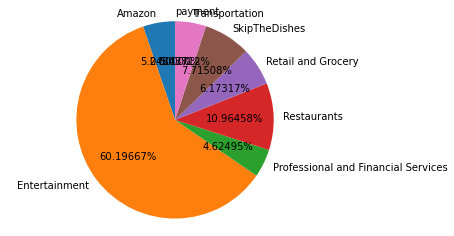

In [37]:

BankingCategories = Comp_df.drop(['cat_id'], axis=1).groupby(["cat"]).sum()
BankingCategories = BankingCategories.reset_index()
#BankingCategories.sum()
print(BankingCategories)
print()
#print (StatementRows.head())
#plot =  StatementRows.plot.pie(y= "Spending Cat")
#print(BankingCategories["Amount"])
#print(BankingCategories["Spending Cat"])

#debtDisplaySum = debt_df.groupby('cat')['credi.sum()
plt.pie(BankingCategories["credit"], labels =  BankingCategories["cat"],autopct='%2.5f%%',startangle=90)
plt.axis('equal')
plt.show()

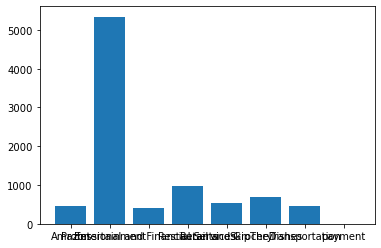

In [38]:
plt.bar(BankingCategories["cat"],BankingCategories["credit"] )
plt.show()

In [53]:
# show top 3 in each cateogry
for key,i in debt_df.groupby('cat'):
    print(key)
    print(i['credit'].sum())
    
    nameCat = i.groupby("name")['credit'].sum()
    print( (nameCat) )

Amazon
465.68
name
AMZN Mktp CA*9N5BE11R3 WWW.AMAZON.CA     28.70
Amazon.ca*9W2WR38W3 AMAZON.CA           426.99
Amazon.ca*W15OH6C83 AMAZON.CA             9.99
Name: credit, dtype: float64
Entertainment
5341.1
name
Sony Interactive Entertai 800-3457669      15.99
THE ATHLETIC PERFORMANCE 9058571131      5325.11
Name: credit, dtype: float64
Professional and Financial Services
410.36
name
DELL CANADA INC 800-WWWDELL    410.36
Name: credit, dtype: float64
Restaurants
972.86
name
A&W # 4903 BOLTON BOLTON                  23.70
BK  BRAMPTON                              28.76
BOOSTER JUICE  BOLTON                     16.02
CHICK-FIL-A YORKDALE MAL NORTH YORK       28.92
CITY SOUTH PIZZA BOLTON                   17.00
DOMINO'S PIZZA  BRAMPTON                   7.77
DOMINOS PIZZA  BRAMPTON                   54.07
EBOOKUNIVERSITYOFWATERLOO KINGSTON        56.49
FIVE GUYS BURGERS AND BRAMPTON            28.90
FOOD FIGHT BBQ BRAMPTON                   60.78
GARDEN FOODS - BOLTON BOLTON           